In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import shap
import seaborn as sns 
import matplotlib.pyplot as plt

# Assuming df is your DataFrame after aggregating to daily data and merging with weather/building data
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Get the number of rows and columns 
# rows = len(df.axes[0]) 
# cols = len(df.axes[1]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   Comms and Services                 40812 non-null  float64
 2   Car Chargers                       40812 non-null  float64
 3   Space Heating                      40812 non-null  float64
 4   Hot Water                          40812 non-null  float64
 5   Sockets                            40812 non-null  float64
 6   Lighting                           40812 non-null  float64
 7   total_energy                       41664 non-null  object 
 8   datepart                           41664 non-null  float64
 9   weekend                            41664 non-null  object 
 10  bank holiday                       41664 non-null  object 
 11  hour                               41664 non-null  flo

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\267611544.py:17: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [99]:
#Defining Function for turning features into cyclic 
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [100]:


# df['month'] = df.datetime.dt.month
df = encode(df, 'month', 12)
df =  encode(df, 'hour', 24)
# df['day'] = df.datetime.dt.day
# df = encode(df, 'day', 31)
df = encode(df, 'day of week', 7)
df = encode(df, 'day of month', 31)


In [101]:
# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Car Chargers','Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   total_energy                       41664 non-null  object 
 2   datepart                           41664 non-null  float64
 3   weekend                            41664 non-null  object 
 4   bank holiday                       41664 non-null  object 
 5   year                               41664 non-null  float64
 6   forecast_datadate                  41664 non-null  object 
 7   forecastperiod                     40766 non-null  object 
 8   forecast_temperature               40766 non-null  float64
 9   forecast_feelslike                 40766 non-null  float64
 10  forecast_weathertype               40766 non-null  float64
 11  forecast_windspeed                 40766 non-null  flo

In [104]:
dates = pd.to_datetime(df['time'])
dates

0       2019-04-01 00:00:00+00:00
1       2019-04-01 01:00:00+00:00
2       2019-04-01 02:00:00+00:00
3       2019-04-01 03:00:00+00:00
4       2019-04-01 04:00:00+00:00
                   ...           
41661   2023-12-31 21:00:00+00:00
41662   2023-12-31 22:00:00+00:00
41663   2023-12-31 23:00:00+00:00
41664                         NaT
41665                         NaT
Name: time, Length: 41666, dtype: datetime64[ns, UTC]

In [113]:
# Generate a list of columns to drop
columns_to_drop = [col for col in df.columns if col.startswith('observation')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25293 entries, 120 to 41663
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               25293 non-null  object 
 1   total_energy                       25293 non-null  object 
 2   datepart                           25293 non-null  float64
 3   weekend                            25293 non-null  object 
 4   bank holiday                       25293 non-null  object 
 5   year                               25293 non-null  float64
 6   forecast_datadate                  25293 non-null  object 
 7   forecastperiod                     25293 non-null  object 
 8   forecast_temperature               25293 non-null  float64
 9   forecast_feelslike                 25293 non-null  float64
 10  forecast_weathertype               25293 non-null  float64
 11  forecast_windspeed                 25293 non-null  float6

In [115]:
df.dropna(inplace=True)
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25293 entries, 120 to 41663
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               25293 non-null  datetime64[ns, UTC]
 1   datepart                           25293 non-null  float64            
 2   year                               25293 non-null  float64            
 3   forecast_temperature               25293 non-null  float64            
 4   forecast_feelslike                 25293 non-null  float64            
 5   forecast_weathertype               25293 non-null  float64            
 6   forecast_windspeed                 25293 non-null  float64            
 7   forecast_uvindex                   25293 non-null  float64            
 8   forecast_precipitationprobability  25293 non-null  float64            
 9   month_sin                          25293 non-null  fl

In [44]:
# Split data into features and target
X = df.drop(['datepart','total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

#gradient-boosted regression model
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

#Ridge Model 
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

#Support Vector Regression 
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

#https://stats.stackexchange.com/questions/255276/normalized-root-mean-square-error-nrmse-with-zero-mean-of-observed-value
# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate Normalised RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)



# Calculate normalised RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Random Forest
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Random Forest, normalised by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Random Forest:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Random Forest:", rf_mape, "%")
print("Random Forest RMSE:", rf_rmse)
print("Random Forest NRMSE:", rf_nrmse)
print("Random Forest rRMSE:", rf_rrmse)



# Calculate nomrlaised RMSE for Gradient-boosted Regression
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
# Calculate Normalised RMSE for Gradient-boosted regression
gbr_nrmse = gbr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Gradient boosting, normalised by the mean of y_test
gbr_rrmse = gbr_rmse / y_mean
# Calculate MAE
gbr_mae = np.mean(np.abs(y_test - y_pred_gbr))
print("Mean Absolute Error (MAE) for Gradient Boosting Regression:", gbr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
gbr_mape = np.mean(np.abs((y_test - y_pred_gbr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression:", gbr_mape, "%")
print("Gradient Boosting Regression RMSE:", gbr_rmse)
print("Gradient Boosting Regression NRMSE:", gbr_nrmse)
print("Gradient Boosting Regression rRMSE:", gbr_rrmse)

# Calculate nomrlaised RMSE for Ridge
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
# Calculate Normalised RMSE for Ridge regression
ridge_nrmse = ridge_rmse / y_range
# Calculate rRMSE (relative RMSE) for Ridge, normalised by the mean of y_test
ridge_rrmse = ridge_rmse / y_mean
# Calculate MAE
ridge_mae = np.mean(np.abs(y_test - y_pred_ridge))
print("Mean Absolute Error (MAE) for Ridge:", ridge_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Ridge:", ridge_mape, "%")
print("Ridge RMSE:", ridge_rmse)
print("Ridge NRMSE:", ridge_nrmse)
print("Ridge rRMSE:", ridge_rrmse)



# Calculate nomrlaised RMSE for Lasso
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
# Calculate Normalised RMSE for Lasso regression
lasso_nrmse = lasso_rmse / y_range
# Calculate rRMSE (relative RMSE) for Lasso, normalised by the mean of y_test
lasso_rrmse = lasso_rmse / y_mean
# Calculate MAE
lasso_mae = np.mean(np.abs(y_test - y_pred_lasso))
print("Mean Absolute Error (MAE) for Lasso:", lasso_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Lasso:", lasso_mape, "%")
print("Lasso RMSE:", lasso_rmse)
print("Lasso NRMSE:", lasso_nrmse)
print("Lasso rRMSE:", lasso_rrmse)

# Calculate nomrlaised RMSE for support vector regression
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
# Calculate Normalised RMSE for support vector regression regression
svr_nrmse = svr_rmse / y_range
# Calculate rRMSE (relative RMSE) for support vector regression, normalised by the mean of y_test
svr_rrmse = svr_rmse / y_mean
# Calculate MAE
svr_mae = np.mean(np.abs(y_test - y_pred_svr))
print("Mean Absolute Error (MAE) for SVR:", svr_mae)

# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
svr_mape = np.mean(np.abs((y_test - y_pred_svr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for SVR:", svr_mape, "%")
print("SVR RMSE:", svr_rmse)
print("SVR NRMSE:", svr_nrmse)
print("SVR rRMSE:", svr_rrmse)



Mean Absolute Error (MAE) for Linear Regression: 0.8067927002626641
Mean Absolute Percentage Error (MAPE) for Linear Regression: 5505531551.05717 %
Linear Regression RMSE: 1.112589512326408
Linear Regression NRMSE: 0.11592378702121968
Linear Regression rRMSE: 0.5458867853953382
Mean Absolute Error (MAE) for Random Forest: 0.6397535345814092
Mean Absolute Percentage Error (MAPE) for Random Forest: 9298077077.955143 %
Random Forest RMSE: 0.9764029936379327
Random Forest NRMSE: 0.10173413593005197
Random Forest rRMSE: 0.4790675137076292
Mean Absolute Error (MAE) for Gradient Boosting Regression: 0.654125219411874
Mean Absolute Percentage Error (MAPE) for Gradient Boosting Regression: 7902707962.179129 %
Gradient Boosting Regression RMSE: 0.9456794095243499
Gradient Boosting Regression NRMSE: 0.098532960490366
Gradient Boosting Regression rRMSE: 0.4639931323821052
Mean Absolute Error (MAE) for Ridge: 0.8067730389674546
Mean Absolute Percentage Error (MAPE) for Ridge: 5505715483.679241 %
Ri

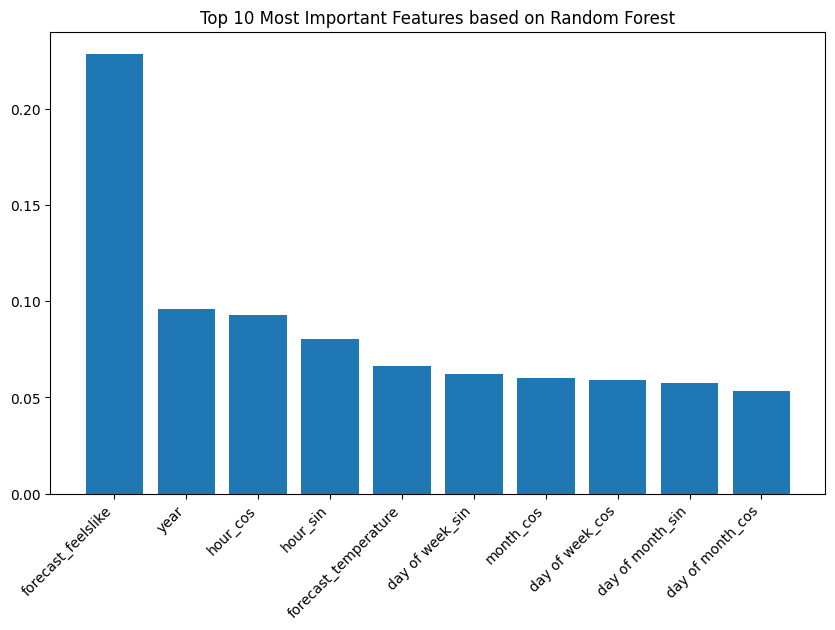

In [11]:

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
feature_names = X_train.columns
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order and select the top 10
indices = np.argsort(importances)[::-1][:10]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))

# Create plot title
plt.title("Top 10 Most Important Features based on Random Forest")

# Add bars
plt.bar(range(10), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(10), names, rotation=45, ha='right')

# Show plot
plt.show()

In [155]:
print(importances)

[0.09593256 0.06648313 0.22852904 0.0199538  0.03326929 0.00797699
 0.05014046 0.03253697 0.06011887 0.08032824 0.09295604 0.06218315
 0.05902532 0.05738093 0.05318521]


In [103]:
df['time']

0        2019-04-01 00:00:00+00
1        2019-04-01 01:00:00+00
2        2019-04-01 02:00:00+00
3        2019-04-01 03:00:00+00
4        2019-04-01 04:00:00+00
                  ...          
41661    2023-12-31 21:00:00+00
41662    2023-12-31 22:00:00+00
41663    2023-12-31 23:00:00+00
41664                       NaN
41665                       NaN
Name: time, Length: 41666, dtype: object

In [109]:
df.dropna(inplace=True)

In [116]:
print(df.dtypes)

time                                 datetime64[ns, UTC]
datepart                                         float64
year                                             float64
forecast_temperature                             float64
forecast_feelslike                               float64
forecast_weathertype                             float64
forecast_windspeed                               float64
forecast_uvindex                                 float64
forecast_precipitationprobability                float64
month_sin                                        float64
month_cos                                        float64
hour_sin                                         float64
hour_cos                                         float64
day of week_sin                                  float64
day of week_cos                                  float64
day of month_sin                                 float64
day of month_cos                                 float64
total_aob_energy               

In [117]:

# Example DataFrame creation
data = {
    'date': ['2019-04-01 00:00:00+00', '2019-04-01 01:00:00+00', '2019-04-01 02:00:00+00',
             '2019-04-01 03:00:00+00', '2019-04-01 04:00:00+00'],
    'value': [1, 2, 3, 4, 5]  # Example values
}
# df['time']= dates
data = pd.DataFrame(df)

# Ensure 'date' column is datetime type
data['time'] = pd.to_datetime(data['time'])

# Set 'date' column as the DataFrame index
data.set_index('time', inplace=True)

# Verify the index is now a DatetimeIndex
print("Index type:", type(data.index))

# Now you can resample
data_daily = data.resample('D').mean()

print(data_daily)


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                           datepart    year  forecast_temperature  \
time                                                                
2019-04-06 00:00:00+00:00   43561.0  2019.0              8.000000   
2019-04-07 00:00:00+00:00   43562.0  2019.0             11.181818   
2019-04-08 00:00:00+00:00   43563.0  2019.0              9.791667   
2019-04-09 00:00:00+00:00   43564.0  2019.0              9.083333   
2019-04-10 00:00:00+00:00   43565.0  2019.0              8.000000   
...                             ...     ...                   ...   
2023-12-27 00:00:00+00:00   45287.0  2023.0             10.750000   
2023-12-28 00:00:00+00:00   45288.0  2023.0              8.750000   
2023-12-29 00:00:00+00:00   45289.0  2023.0              9.375000   
2023-12-30 00:00:00+00:00   45290.0  2023.0              9.000000   
2023-12-31 00:00:00+00:00   45291.0  2023.0              8.875000   

                           forecast_

In [125]:
# data_daily.index = data_daily.index.date

# Now your DataFrame's index should be in the 'YYYY-MM-DD' format without the time component
# data_daily.info()
data_daily.dropna(inplace=True)

In [128]:
data_daily

,datepart,year,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,month_sin,month_cos,hour_sin,hour_cos,day of week_sin,day of week_cos,day of month_sin,day of month_cos,total_aob_energy
2019-04-06,43561.0,2019.0,8.000000,5.500000,7.000000,11.500000,0.250000,3.250000,8.660254e-01,-0.5,4.311862e-01,6.432830e-01,-0.781831,0.623490,9.377521e-01,0.347305,1.780730
2019-04-07,43562.0,2019.0,11.181818,9.545455,4.181818,9.909091,1.545455,4.272727,8.660254e-01,-0.5,-4.785275e-01,-5.680404e-02,0.000000,1.000000,9.884683e-01,0.151428,1.557236
2019-04-08,43563.0,2019.0,9.791667,8.291667,8.708333,8.583333,0.750000,28.000000,8.660254e-01,-0.5,-1.619075e-17,-5.088522e-17,0.781831,0.623490,9.987165e-01,-0.050649,3.403896
2019-04-09,43564.0,2019.0,9.083333,6.750000,2.208333,10.166667,1.458333,3.708333,8.660254e-01,-0.5,-1.619075e-17,-5.088522e-17,0.974928,-0.222521,9.680771e-01,-0.250653,3.486373
2019-04-10,43565.0,2019.0,8.000000,5.291667,0.625000,11.625000,1.458333,0.000000,8.660254e-01,-0.5,-1.619075e-17,-5.088522e-17,0.433884,-0.900969,8.978045e-01,-0.440394,3.696560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,45287.0,2023.0,10.750000,6.000000,11.708333,33.125000,0.375000,52.833333,-2.449294e-16,1.0,-1.619075e-17,-5.088522e-17,0.433884,-0.900969,-7.247928e-01,0.688967,1.766175
2023-12-28,45288.0,2023.0,8.750000,5.000000,9.041667,20.791667,0.375000,38.125000,-2.449294e-16,1.0,-1.619075e-17,-5.088522e-17,-0.433884,-0.900969,-5.712682e-01,0.820763,1.938858
2023-12-29,45289.0,2023.0,9.375000,5.833333,11.000000,20.458333,0.375000,48.250000,-2.449294e-16,1.0,-1.619075e-17,-5.088522e-17,-0.974928,-0.222521,-3.943559e-01,0.918958,2.149062
2023-12-30,45290.0,2023.0,9.000000,4.166667,12.458333,29.250000,0.375000,65.916667,-2.449294e-16,1.0,-1.619075e-17,-5.088522e-17,-0.781831,0.623490,-2.012985e-01,0.979530,1.677269


In [ ]:
dates = data_daily

In [126]:
# Split data into features and target
X = data_daily.drop(['datepart','total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = data_daily['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training
# Linear Regression
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Calculate range of the target variable
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculate Normalised RMSE for Linear Regression
rf_nrmse = rf_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
rf_rrmse = rf_rmse / y_mean
# Calculate MAE
rf_mae = np.mean(np.abs(y_test - y_pred_rf))
print("Mean Absolute Error (MAE) for Linear Regression:", rf_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", rf_mape, "%")

print("Linear Regression RMSE:", rf_rmse)
print("Linear Regression NRMSE:", rf_nrmse)
print("Linear Regression rRMSE:", rf_rrmse)




Mean Absolute Error (MAE) for Linear Regression: 0.3115618277536241
Mean Absolute Percentage Error (MAPE) for Linear Regression: 19.42940625096584 %
Linear Regression RMSE: 0.4181778911685568
Linear Regression NRMSE: 0.09679250350843431
Linear Regression rRMSE: 0.24442389442781332


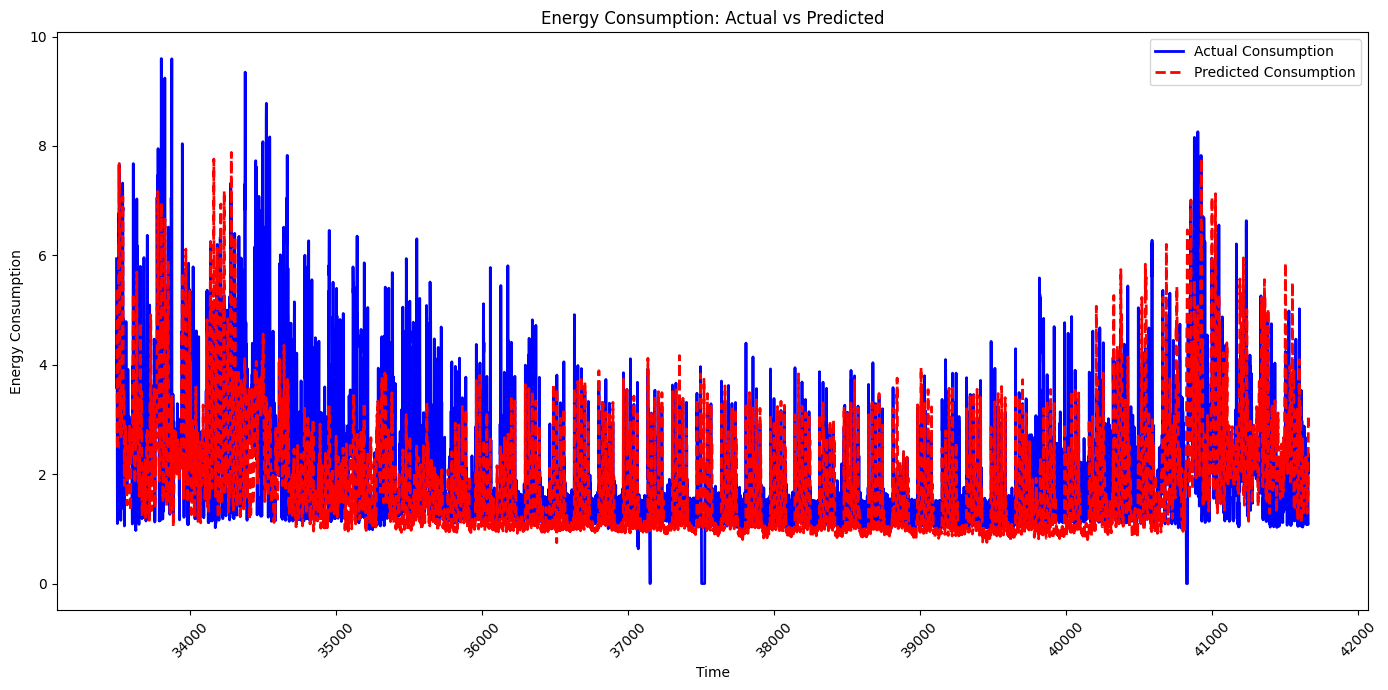

In [24]:
# dates = pd.to_datetime(dates)

# Create a DataFrame for easier plotting
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
})

# Sort the DataFrame by date if it's not already sorted

# Plotting
plt.figure(figsize=(14, 7))
plt.plot( df['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot( df['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optionally, you can limit the displayed range to a specific period for a clearer view
# plt.xlim([pd.Timestamp('YYYY-MM-DD'), pd.Timestamp('YYYY-MM-DD')])

plt.tight_layout()  # Adjust the layout to make room for the rotated date labels
plt.show()

In [131]:
y_test

2023-05-28    1.209702
2023-05-29    1.374067
2023-05-30    1.779897
2023-05-31    1.592341
2023-06-01    1.592352
                ...   
2023-12-27    1.766175
2023-12-28    1.938858
2023-12-29    2.149062
2023-12-30    1.677269
2023-12-31    1.763823
Name: total_aob_energy, Length: 218, dtype: float64

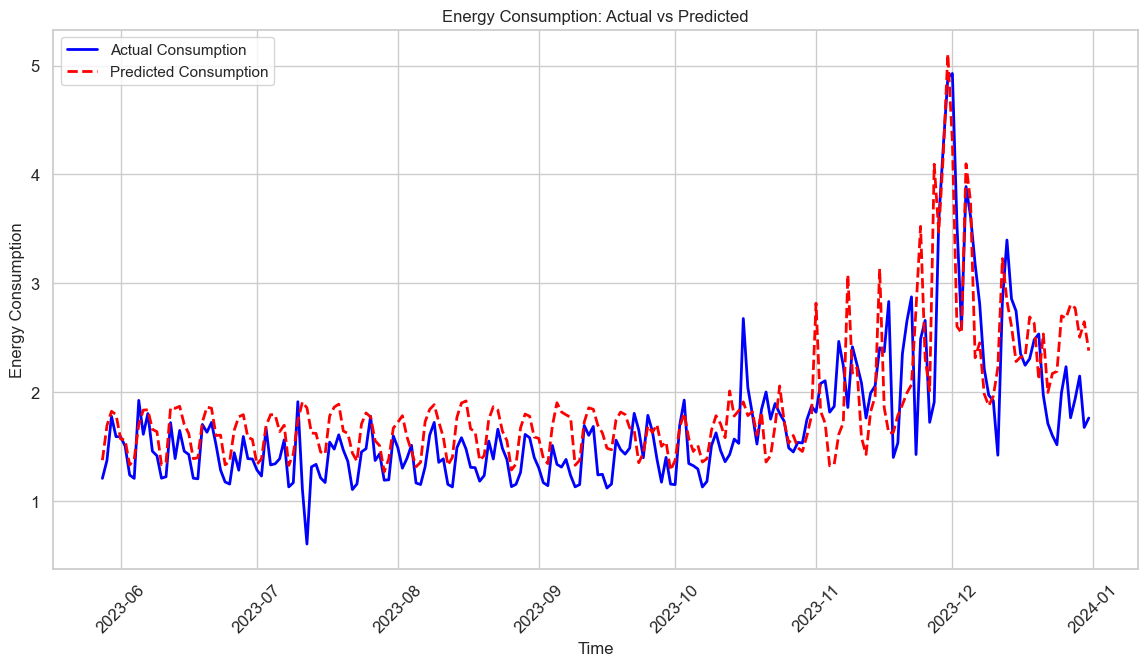

In [138]:
df_error = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
}, index=y_test.index)  # Use 'dates' as the index

# Ensure the DataFrame is sorted by date
df_error.sort_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_error.index, df_error['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=2)
plt.plot(df_error.index, df_error['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

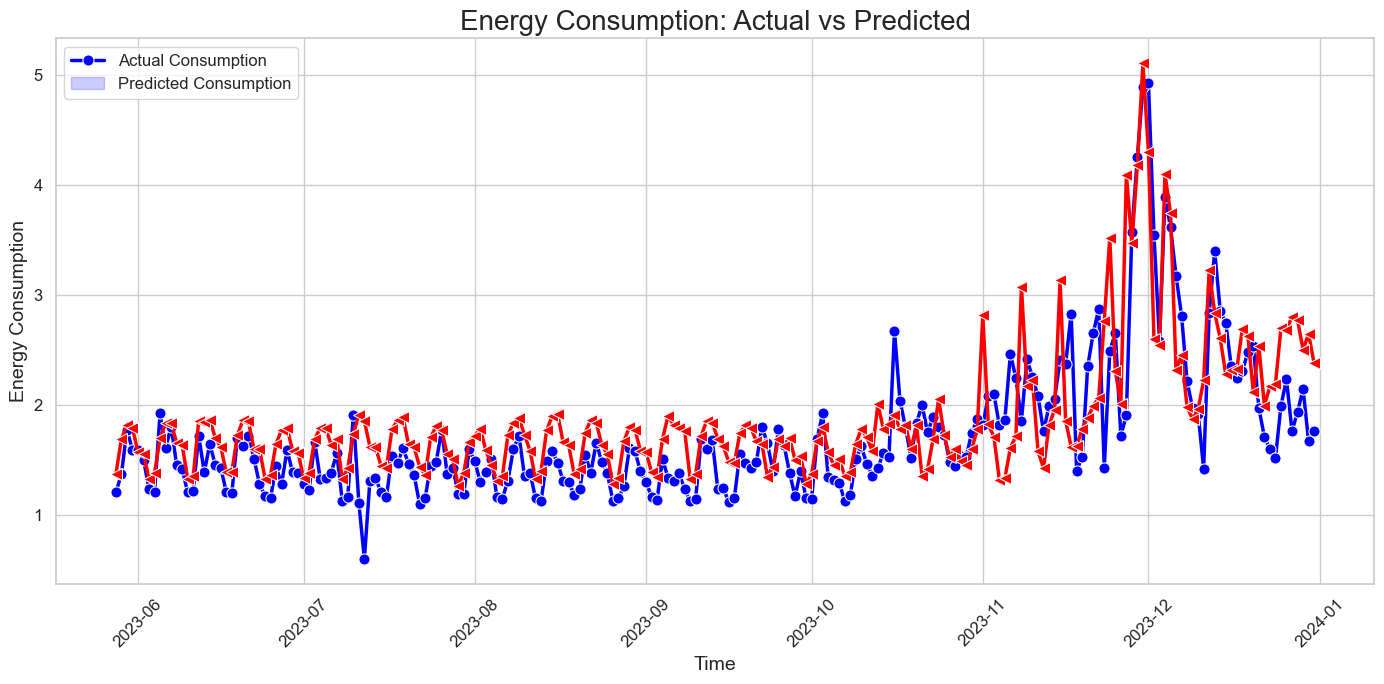

In [137]:
sns.set(style="whitegrid")  # This sets a nice background grid and improves overall aesthetics

# Plotting with Seaborn's lineplot function for automatic handling of datetime x-axis and improved aesthetics
plt.figure(figsize=(14, 7))

sns.lineplot(data=df_error, palette=['blue', 'red'], linewidth=2.5, dashes=False, markers=["o", "<"], markersize=8)

plt.title('Energy Consumption: Actual vs Predicted', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend(labels=['Actual Consumption', 'Predicted Consumption'], fontsize=12)

# Improve readability of the x-axis labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout
plt.tight_layout()

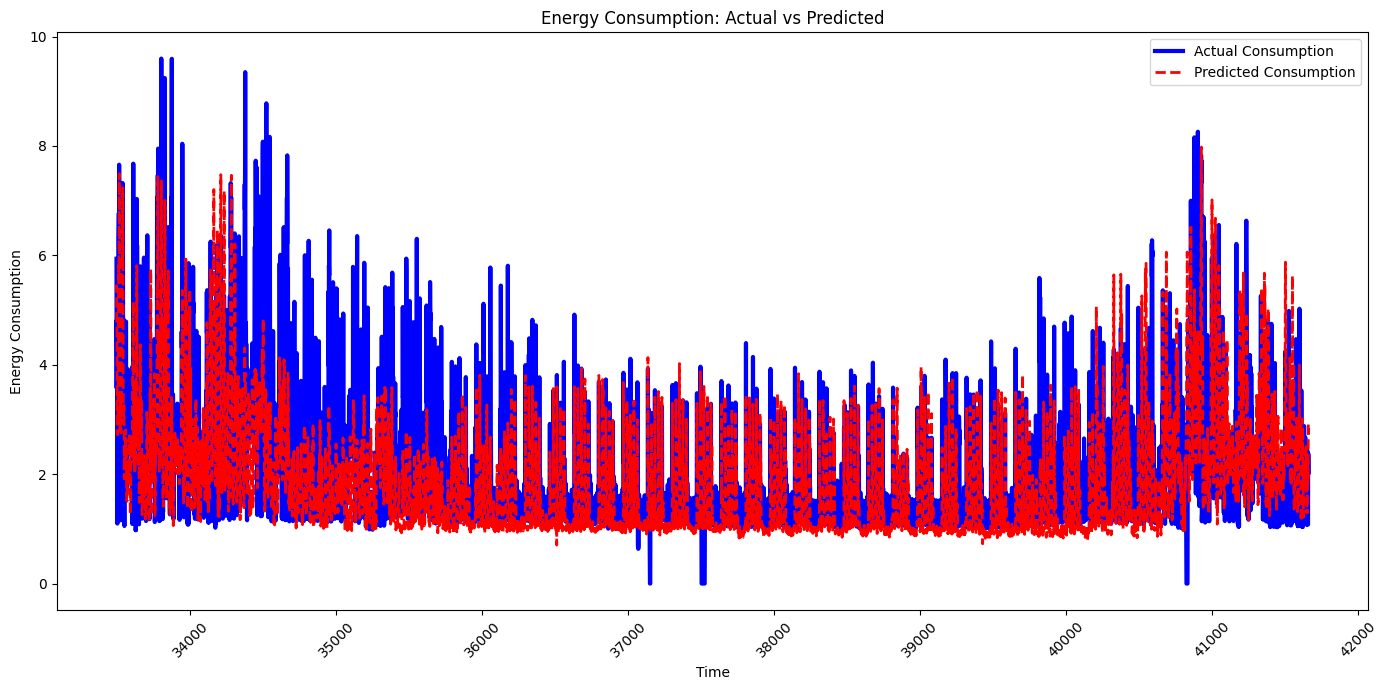

In [68]:
dates = dates[-8154:]
# dates = pd.to_datetime(dates)
# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Actual Consumption': y_test,
    'Predicted Consumption': y_pred_rf
})

# Sort the DataFrame by date if it's not already sorted
# df = df.sort_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Actual Consumption'], label='Actual Consumption', color='blue', linewidth=3)
plt.plot(df['Predicted Consumption'], label='Predicted Consumption', color='red', linestyle='--', linewidth=2)

plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Optionally, you can limit the displayed range to a specific period for a clearer view
# plt.xlim([pd.Timestamp('YYYY-MM-DD'), pd.Timestamp('YYYY-MM-DD')])

plt.tight_layout()  # Adjust the layout to make room for the rotated date labels
plt.show()

In [69]:

# Get the current date and time
current_timestamp = datetime.now()

# Format the timestamp without seconds
formatted_timestamp = current_timestamp.strftime('%Y-%m-%d %H:%M')

print("Formatted Timestamp:", formatted_timestamp)

Formatted Timestamp: 2024-03-21 05:47


In [72]:
# Assuming y_test, y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr are defined
# Define a dictionary to hold the results
results = {
    "Method": [],
    "RMSE": [],
    "NRMSE": [],
    "rRMSE": [],
    "MAE": [],
    "MAPE": []
}

methods = ["Linear Regression", "Random Forest", "Gradient Boosting Regression", "Ridge", "Lasso", "SVR"]
predictions = [y_pred_lr, y_pred_rf, y_pred_gbr, y_pred_ridge, y_pred_lasso, y_pred_svr]

y_range = np.max(y_test) - np.min(y_test)
y_mean = np.mean(y_test)
i = 0
for method, y_pred in zip(methods, predictions):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculate NRMSE
    nrmse = rmse / y_range
    # Calculate rRMSE
    rrmse = rmse / y_mean
    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

    # Append the results
    results["Method"].append(method)
    results["RMSE"].append(rmse)
    results["NRMSE"].append(nrmse)
    results["rRMSE"].append(rrmse)
    results["MAE"].append(mae)
    results["MAPE"].append(mape)

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)
name = f"regression_metrics_AOBresults{formatted_timestamp}.csv"

try:
    results_df.to_csv(name, index=False)
    print("Results saved to", name)
except Exception as e:
    print("Error saving the file:", e)
# Save the DataFrame to a CSV file
# results_df.to_csv(name)

# print("Results saved to ",name)

Results saved to regression_metrics_AOBresults2024-03-21 05:47.csv


In [73]:
import os
print(os.getcwd())

c:\AOB\AOB_Energy_Consumption_Analysis_Prediction


In [75]:
results_df.head()
results_df.to_csv("regression_metrics_AOBresults2024-03-21 22", index=False)

In [139]:
display(df)

,time,datepart,year,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,month_sin,month_cos,hour_sin,hour_cos,day of week_sin,day of week_cos,day of month_sin,day of month_cos,total_aob_energy
120,2019-04-06 00:00:00+00:00,43561.0,2019.0,8.0,6.0,7.0,11.0,0.0,3.0,8.660254e-01,-0.5,0.000000,1.000000,-0.781831,0.62349,9.377521e-01,0.347305,1.822014
121,2019-04-06 01:00:00+00:00,43561.0,2019.0,8.0,6.0,7.0,11.0,0.0,3.0,8.660254e-01,-0.5,0.258819,0.965926,-0.781831,0.62349,9.377521e-01,0.347305,1.794794
122,2019-04-06 02:00:00+00:00,43561.0,2019.0,8.0,6.0,7.0,11.0,0.0,3.0,8.660254e-01,-0.5,0.500000,0.866025,-0.781831,0.62349,9.377521e-01,0.347305,1.757064
127,2019-04-06 07:00:00+00:00,43561.0,2019.0,8.0,4.0,7.0,13.0,1.0,4.0,8.660254e-01,-0.5,0.965926,-0.258819,-0.781831,0.62349,9.377521e-01,0.347305,1.749047
154,2019-04-07 10:00:00+00:00,43562.0,2019.0,10.0,8.0,7.0,11.0,2.0,9.0,8.660254e-01,-0.5,0.500000,-0.866025,0.000000,1.00000,9.884683e-01,0.151428,1.748828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41659,2023-12-31 19:00:00+00:00,45291.0,2023.0,10.0,6.0,15.0,22.0,0.0,96.0,-2.449294e-16,1.0,-0.965926,0.258819,0.000000,1.00000,-2.449294e-16,1.000000,1.079359
41660,2023-12-31 20:00:00+00:00,45291.0,2023.0,10.0,6.0,15.0,22.0,0.0,97.0,-2.449294e-16,1.0,-0.866025,0.500000,0.000000,1.00000,-2.449294e-16,1.000000,2.365750
41661,2023-12-31 21:00:00+00:00,45291.0,2023.0,11.0,7.0,15.0,34.0,0.0,96.0,-2.449294e-16,1.0,-0.707107,0.707107,0.000000,1.00000,-2.449294e-16,1.000000,2.376105
41662,2023-12-31 22:00:00+00:00,45291.0,2023.0,11.0,7.0,15.0,34.0,0.0,96.0,-2.449294e-16,1.0,-0.500000,0.866025,0.000000,1.00000,-2.449294e-16,1.000000,2.342148


C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\2759908011.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['Energy Level'] = energy_bins


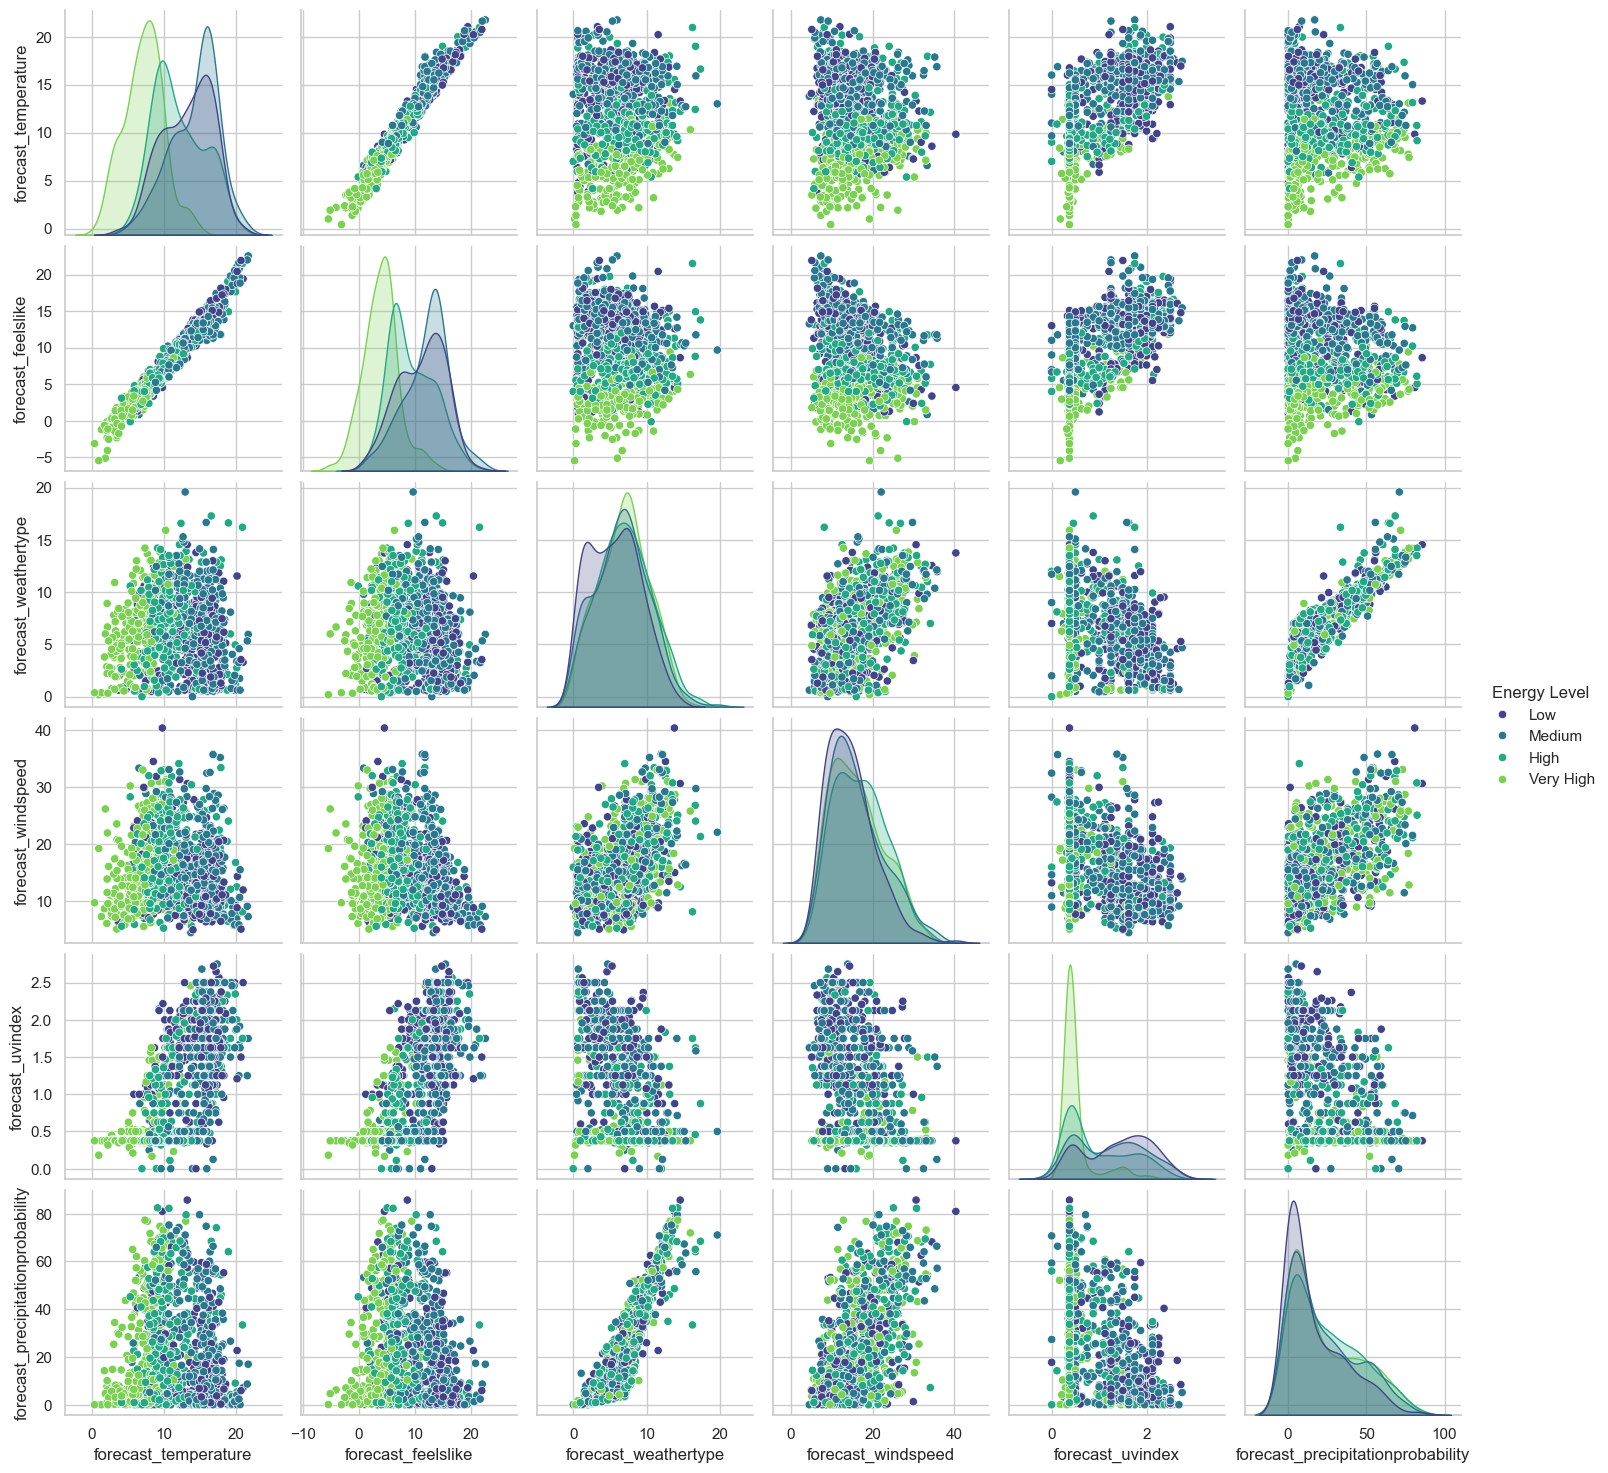

In [146]:
# Generate a list of columns to drop
forecast_columns = [col for col in data_daily.columns if col.startswith('forecast')]
# display(forecast_columns)
energy_bins = pd.qcut(data_daily['total_aob_energy'], q=4, labels=["Low", "Medium", "High", "Very High"])
# Drop these columns from the DataFrame
# df = df.drop(columns=columns_to_drop)
df_forecast = data_daily[forecast_columns]

df_forecast['Energy Level'] = energy_bins

# Plot using pairplot with the new 'Energy Level' column as hue
sns.pairplot(df_forecast, hue='Energy Level', palette="viridis")

In [149]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 2019-04-06 to 2023-12-31
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   forecast_temperature               1087 non-null   float64 
 1   forecast_feelslike                 1087 non-null   float64 
 2   forecast_weathertype               1087 non-null   float64 
 3   forecast_windspeed                 1087 non-null   float64 
 4   forecast_uvindex                   1087 non-null   float64 
 5   forecast_precipitationprobability  1087 non-null   float64 
 6   Energy Level                       1087 non-null   category
dtypes: category(1), float64(6)
memory usage: 93.0+ KB


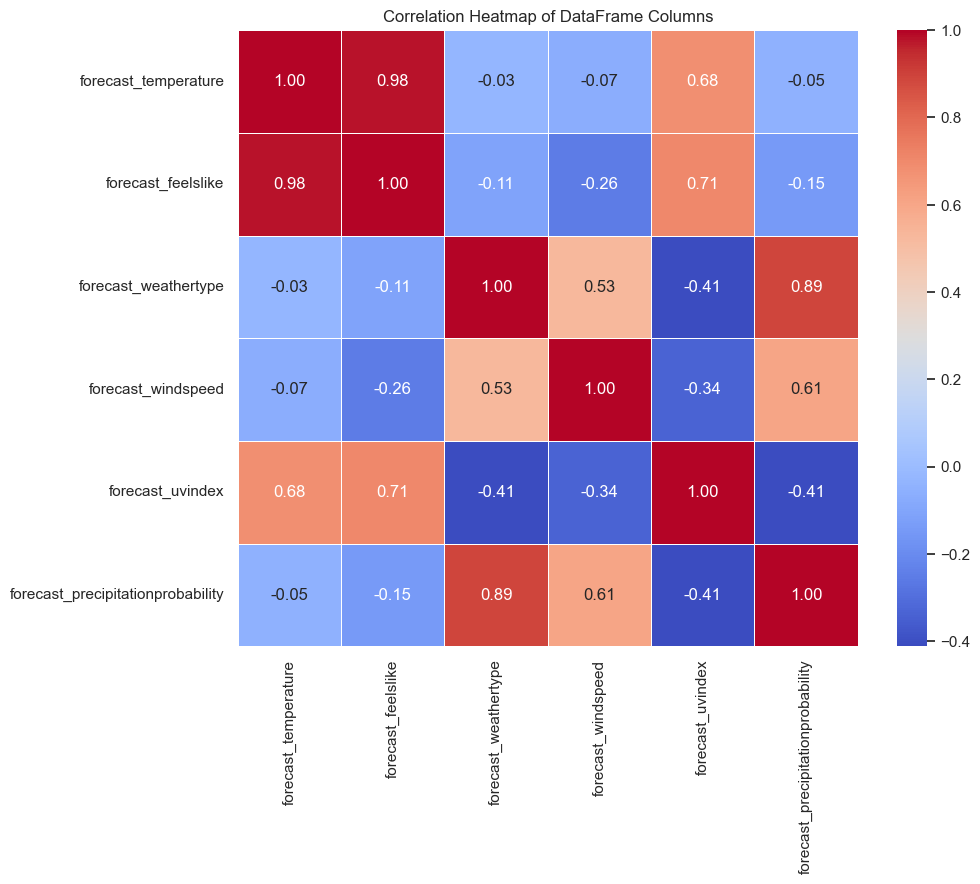

In [152]:

df_forecast = df_forecast.drop(['Energy Level'], axis = 1 )

# Calculate the correlation matrix
correlation_matrix = df_forecast.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

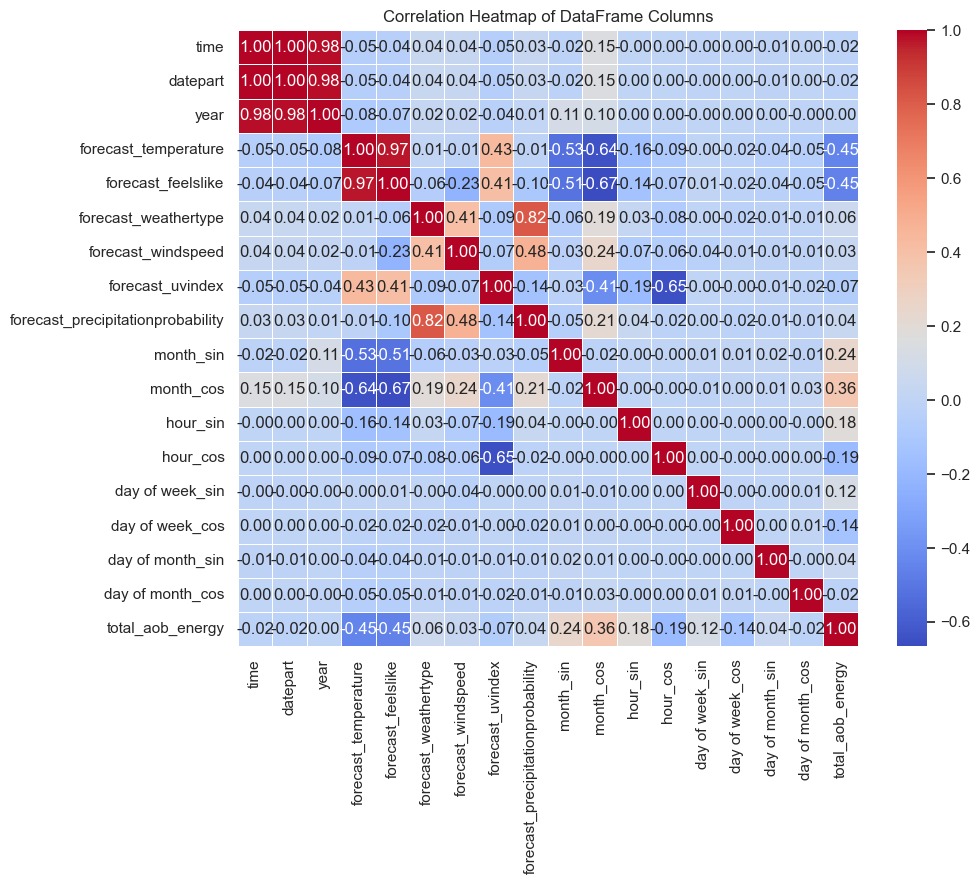

In [154]:


# Calculate the correlation matrix
correlation_matrix0 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25293 entries, 120 to 41663
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   time                               25293 non-null  datetime64[ns, UTC]
 1   datepart                           25293 non-null  float64            
 2   year                               25293 non-null  float64            
 3   forecast_temperature               25293 non-null  float64            
 4   forecast_feelslike                 25293 non-null  float64            
 5   forecast_weathertype               25293 non-null  float64            
 6   forecast_windspeed                 25293 non-null  float64            
 7   forecast_uvindex                   25293 non-null  float64            
 8   forecast_precipitationprobability  25293 non-null  float64            
 9   month_sin                          25293 non-null  fl

In [156]:
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
df.dropna(inplace=True)
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24801 entries, 120 to 41663
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Comms and Services                 24801 non-null  float64
 1   Car Chargers                       24801 non-null  float64
 2   Space Heating                      24801 non-null  float64
 3   Hot Water                          24801 non-null  float64
 4   Sockets                            24801 non-null  float64
 5   Lighting                           24801 non-null  float64
 6   datepart                           24801 non-null  float64
 7   hour                               24801 non-null  float64
 8   day of week                        24801 non-null  float64
 9   day of month                       24801 non-null  float64
 10  month                              24801 non-null  float64
 11  year                               24801 non-null  float6

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\1235424168.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [158]:
columns_to_drop = [col for col in df.columns if col.startswith('forecast')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24801 entries, 120 to 41663
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Comms and Services       24801 non-null  float64
 1   Car Chargers             24801 non-null  float64
 2   Space Heating            24801 non-null  float64
 3   Hot Water                24801 non-null  float64
 4   Sockets                  24801 non-null  float64
 5   Lighting                 24801 non-null  float64
 6   datepart                 24801 non-null  float64
 7   hour                     24801 non-null  float64
 8   day of week              24801 non-null  float64
 9   day of month             24801 non-null  float64
 10  month                    24801 non-null  float64
 11  year                     24801 non-null  float64
 12  observation_temperature  24801 non-null  float64
 13  observation_windspeed    24801 non-null  float64
 14  observation_pressure     

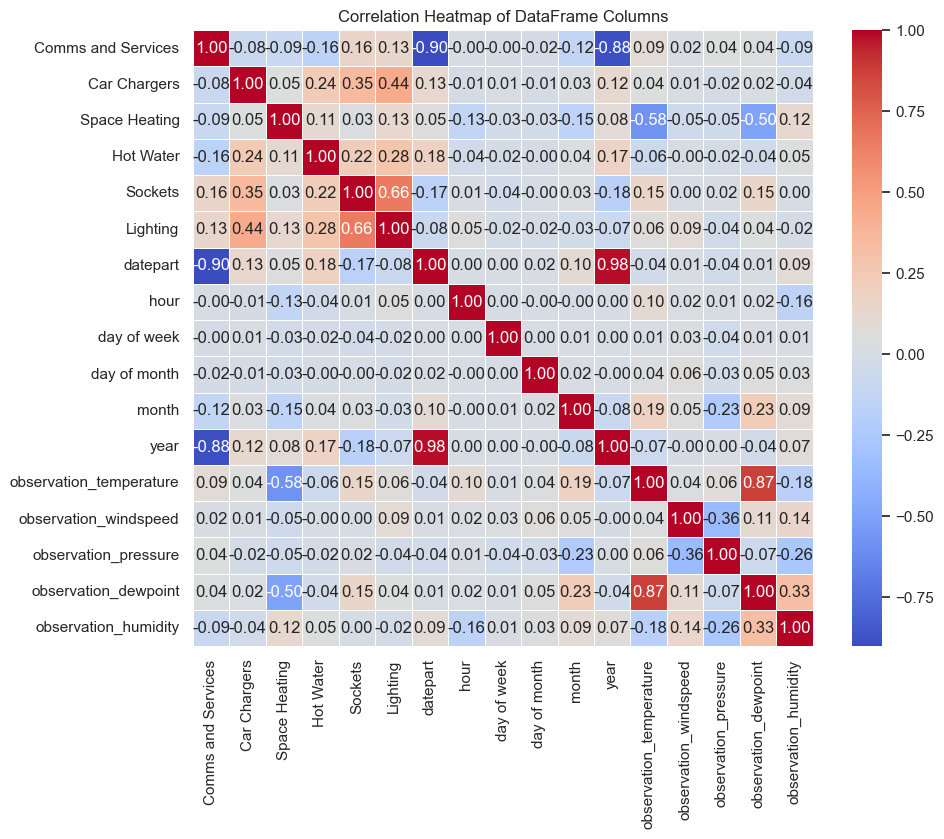

In [159]:

# Calculate the correlation matrix
correlation_matrix0 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

In [160]:
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
columns_to_drop = [col for col in df.columns if col.startswith('observation')]
df = df.drop(columns=columns_to_drop)
df.dropna(inplace=True)

# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'
# Drop these columns from the DataFrame
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40131 entries, 112 to 41663
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Car Chargers                       40131 non-null  float64
 1   datepart                           40131 non-null  float64
 2   year                               40131 non-null  float64
 3   forecast_temperature               40131 non-null  float64
 4   forecast_feelslike                 40131 non-null  float64
 5   forecast_weathertype               40131 non-null  float64
 6   forecast_windspeed                 40131 non-null  float64
 7   forecast_uvindex                   40131 non-null  float64
 8   forecast_precipitationprobability  40131 non-null  float64
 9   total_aob_energy                   40131 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_41744\903110072.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [167]:
df = df.drop(['datepart', 'year'], axis = 1)

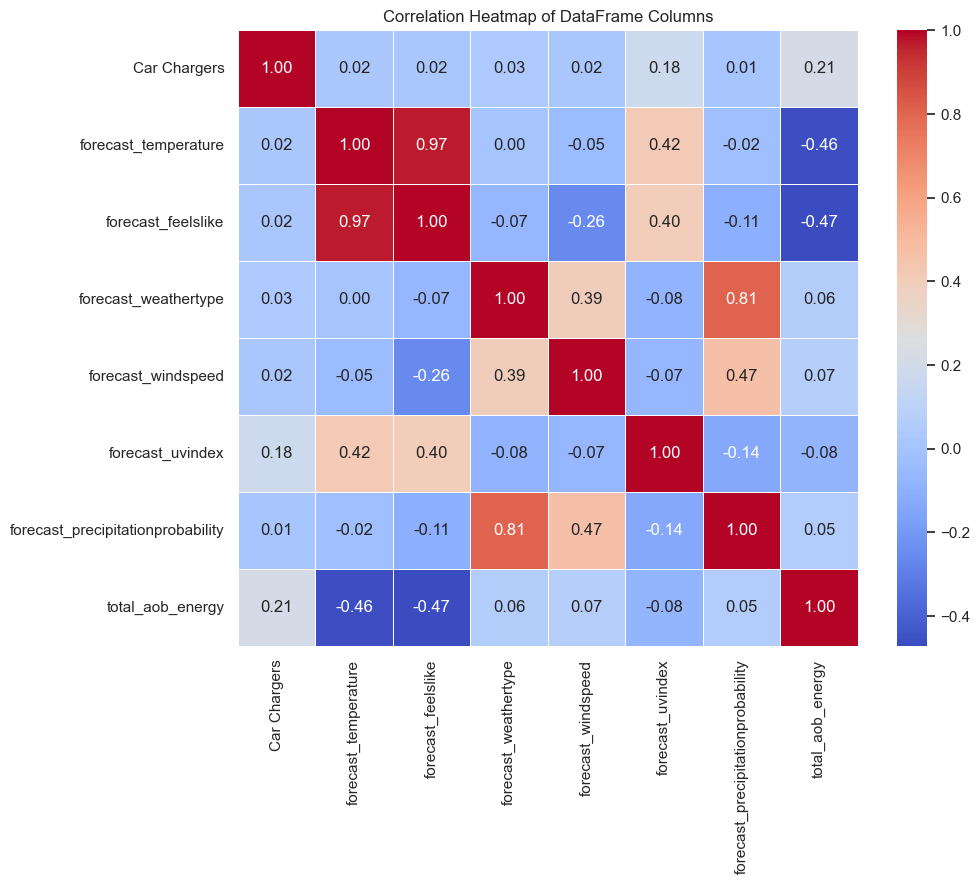

In [168]:
# Calculate the correlation matrix
correlation_matrix1 = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()